<a href="https://colab.research.google.com/github/seanzhu815/415/blob/main/415_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part1

In [74]:
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import math as math
import matplotlib.pyplot as plt


## a

In [75]:
url = "https://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_AT_BDL_tract.csv"
df = pd.read_csv(url)

## b

In [76]:
dfFiltered = df[(df['year'] >= 1990)]
dfFiltered = dfFiltered[dfFiltered['annual_change'] != "."]
dfFiltered['annual_change'] = dfFiltered['annual_change'].astype(float)

## c

In [77]:
dfCrosswalk = pd.read_csv('drive/MyDrive/tract-metro-crosswalk.csv')
dfSD = dfCrosswalk[dfCrosswalk['metro'] == 41740]

## d

In [78]:
dfDistance = pd.read_csv('drive/MyDrive/tract-centrality.csv')
dfDistance = dfDistance.dropna(subset=['distance_to_city_center'])

## e

In [79]:
dfSD = dfDistance.merge(dfSD, how = 'inner', left_on = 'tract', right_on = 'tract')
dfSD

,tract,distance_to_city_center,metro
0,6059032023,32.046215,41740
1,6059042103,39.797086,41740
2,6059042106,38.304827,41740
3,6059042107,38.483711,41740
4,6059042108,38.999774,41740
...,...,...,...
575,6073021400,3.586714,41740
576,6073021500,16.344071,41740
577,6073021800,2.433203,41740
578,6073022000,4.982559,41740


## f

In [80]:
dfSD['quintile'] = pd.qcut(dfSD['distance_to_city_center'], 5, labels = False) + 1
dfSD['quintile'] 

0      5
1      5
2      5
3      5
4      5
      ..
575    1
576    3
577    1
578    1
579    4
Name: quintile, Length: 580, dtype: int64

In [81]:
dfSD = dfFiltered.merge(dfSD, how = 'inner', left_on = 'tract', right_on = 'tract')

## g

In [82]:
gradientSD = dfSD.groupby('quintile')['annual_change'].mean()
stdSD=dfSD.groupby('quintile')['annual_change'].std()

In [ ]:
plot = gradientSD.plot.bar()
plot.set(xlabel = "Quintile of Centrality to City Center", ylabel = "Average Return, 1990-2021", 
        title = "San Diego, CA")
plot.get_figure().savefig("distance-gradient-sd.png")

plot.cla() 

In [84]:
stdSD

quintile
1    11.539347
2    10.099084
3     9.822440
4     9.421892
5    10.513770
Name: annual_change, dtype: float64

In [ ]:
plot = stdSD.plot.bar()
plot.set(xlabel = "Quintile of Centrality to City Center", ylabel = "Standard Deviation of Return, 1990-2021", 
        title = "San Diego, CA")
plot.get_figure().savefig("distance-std-sd.png")
plot.cla() 

## h

In [ ]:
Sharpe_r=gradientSD/stdSD
Sharpe_r

quintile
1    0.499817
2    0.501913
3    0.493753
4    0.482413
5    0.440061
Name: annual_change, dtype: float64

In [ ]:
plot = Sharpe_r.plot.bar()
plot.set(xlabel = "Quintile of Centrality to City Center", ylabel = "Sharpe Ratio, 1990-2021", 
        title = "San Diego, CA")
plot.get_figure().savefig("distance-Sharpe_r-sd.png")
plot.cla() 

# part2

## a

In [85]:
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import math as math
import matplotlib.pyplot as plt
df = pd.read_csv('drive/MyDrive/hmda-2016.csv')

##b

In [86]:
dfs=df.sample(frac=0.8,replace=False,random_state=1)

## c

In [87]:
dfs = dfs[(dfs['editStatus'] == " ") & (dfs['loanPurpose'] == 1) & 
          (dfs['occupancy'] == 1) & (dfs['propType'] == 1) & (dfs['income'] != "NA  ")]

##d

In [88]:
dfs['originated'] = (dfs["action"] == 1).astype(int)
dfs['denied'] = (dfs["action"] == 3).astype(int)
dfs['lti'] = dfs['amount'].astype(float) / dfs['income'].astype(float)
#African- American or Hispanic
dfs['minority'] = ((dfs['appEth'] == 1) | (dfs['appRace1'] == 3)).astype(int)
dfs['majority'] = ((dfs['appEth'] != 1) & (dfs['appRace1'] != 3)).astype(int)

##e

Optimization terminated successfully.
         Current function value: 0.282519
         Iterations 7


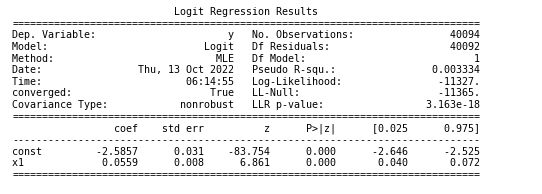

In [91]:
x1 = sm.add_constant(np.array(dfs['lti']))
y = np.array(dfs['denied'])
# Estimate Logistic Regression
resultLogit = sm.Logit(y, x1).fit()
plt.rc('figure', figsize=(8, 3))
plt.text(0.01, 0.05, str(resultLogit.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('output1.png')


In [93]:
# Calculate Prediction
predLogit = 1 / (1 + np.exp(- np.sum(x1 * resultLogit.params, axis = 1)))
predLogit

array([0.07322027, 0.07685877, 0.08469864, ..., 0.0791198 , 0.07589692,
       0.59369023])

##g

In [43]:
x2 = sm.add_constant(np.transpose(np.array([dfs['lti'] , dfs['minority']])))
y = np.array(dfs['denied'])
# Estimate Logistic Regression
resultLogit_new = sm.Logit(y, x2).fit()
print(resultLogit_new.summary())

Optimization terminated successfully.
         Current function value: 0.280794
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40094
Model:                          Logit   Df Residuals:                    40091
Method:                           MLE   Df Model:                            2
Date:                Thu, 13 Oct 2022   Pseudo R-squ.:                0.009418
Time:                        05:30:36   Log-Likelihood:                -11258.
converged:                       True   LL-Null:                       -11365.
Covariance Type:            nonrobust   LLR p-value:                 3.265e-47
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6801      0.032    -84.551      0.000      -2.742      -2.618
x1             0.0501      0.

In [94]:
predLogit_new = 1 / (1 + np.exp(- np.sum(x2 * resultLogit_new.params, axis = 1)))
predLogit_new

array([0.0667617 , 0.06974928, 0.12074764, ..., 0.07159998, 0.06896066,
       0.49421686])

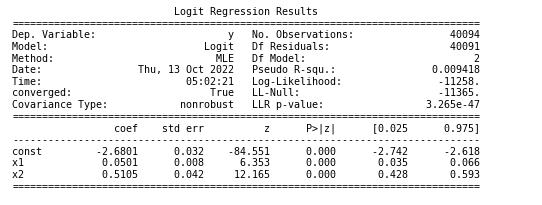

In [26]:
plt.rc('figure', figsize=(8, 3))
plt.text(0.01, 0.05, str(resultLogit_new.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('output2.png')

##h

In [72]:
dfs.columns

Index(['year', 'id', 'agency', 'loanType', 'propType', 'loanPurpose',
       'occupancy', 'amount', 'action', 'msa', 'state', 'county', 'tract',
       'appEth', 'appRace1', 'appSex', 'income', 'purchaserType', 'editStatus',
       'tractMSAInc', 'numOwnerOccUnits', 'num1to4FamUnits', 'originated',
       'denied', 'lti', 'minority', 'majority'],
      dtype='object')

In [73]:
x3 = sm.add_constant(np.transpose(np.array([dfs['appSex'], dfs['minority']])))
y = np.array(dfs['denied'])
# Estimate Logistic Regression
resultLogit_mj = sm.Logit(y, x3).fit()
print(resultLogit_mj.summary())

Optimization terminated successfully.
         Current function value: 0.281604
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40094
Model:                          Logit   Df Residuals:                    40091
Method:                           MLE   Df Model:                            2
Date:                Thu, 13 Oct 2022   Pseudo R-squ.:                0.006563
Time:                        05:58:54   Log-Likelihood:                -11291.
converged:                       True   LL-Null:                       -11365.
Covariance Type:            nonrobust   LLR p-value:                 4.030e-33
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5036      0.044    -56.521      0.000      -2.590      -2.417
x1            -0.0187      0.

##i

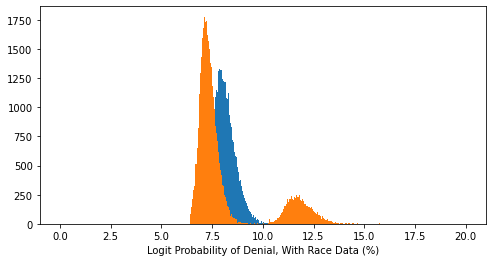

In [97]:
plt.rc('figure', figsize=(8, 4))
plot = plt.hist(100 / (1 + np.exp(- np.sum(x1 * resultLogit.params, axis = 1))), bins = 'auto', 
               range = (0, 20))
plt.xlabel("Logit Probability of Denial (%)")
plt.savefig("logit-denied-LTI.png")

plt.rc('figure', figsize=(8, 4))
plot = plt.hist(100 / (1 + np.exp(- np.sum(x2 * resultLogit_new.params, axis = 1))), bins = 'auto', 
               range = (0, 20))
plt.xlabel("Logit Probability of Denial, With Race Data (%)")
plt.savefig("logit-denied-LTI-minority.png")